In [40]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [41]:
# read in dataset Jill
dset = pd.read_csv('SarahFox3.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

14461
24.101666666666667


In [42]:
#Variables
f=10

# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
#d = pd.DataFrame(data = dset[0:25000]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = (d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])).apply(np.sqrt)

# movement data angular velocity
d['gyr'] = (d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])).apply(np.sqrt)

Autonomic: 11.5366666667 minutes
Autonomic light: 10.8 minutes
Normal breathing: 0.778333333333 minutes
Cardio: 0.0 minutes
 Total: 23.115 minutes


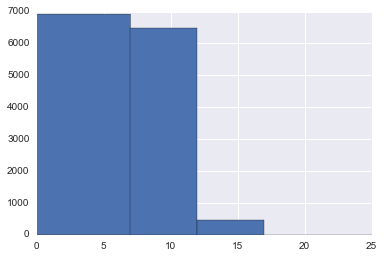

In [43]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/600
b2=n[1]/600
b3=n[2]/600
b4=n[3]/600

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print(" Total: " + str(b1+b2+b3+b4) + " minutes")

In [44]:
f = d

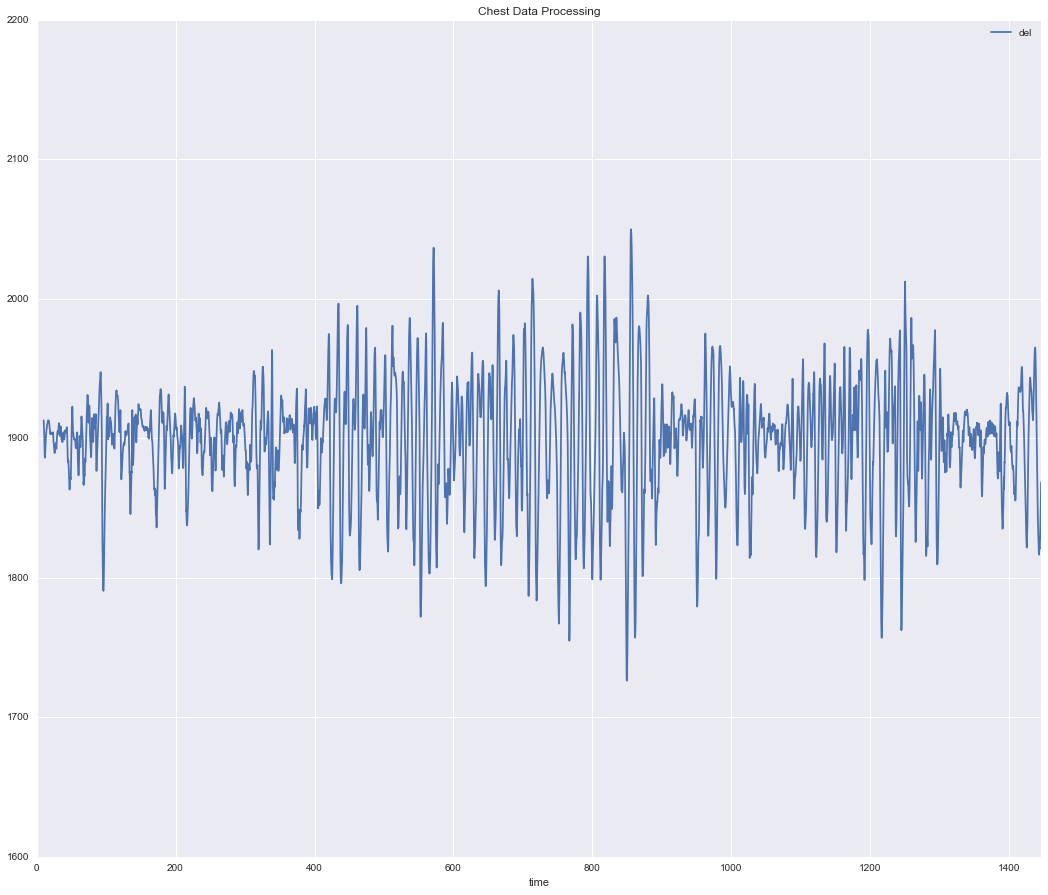

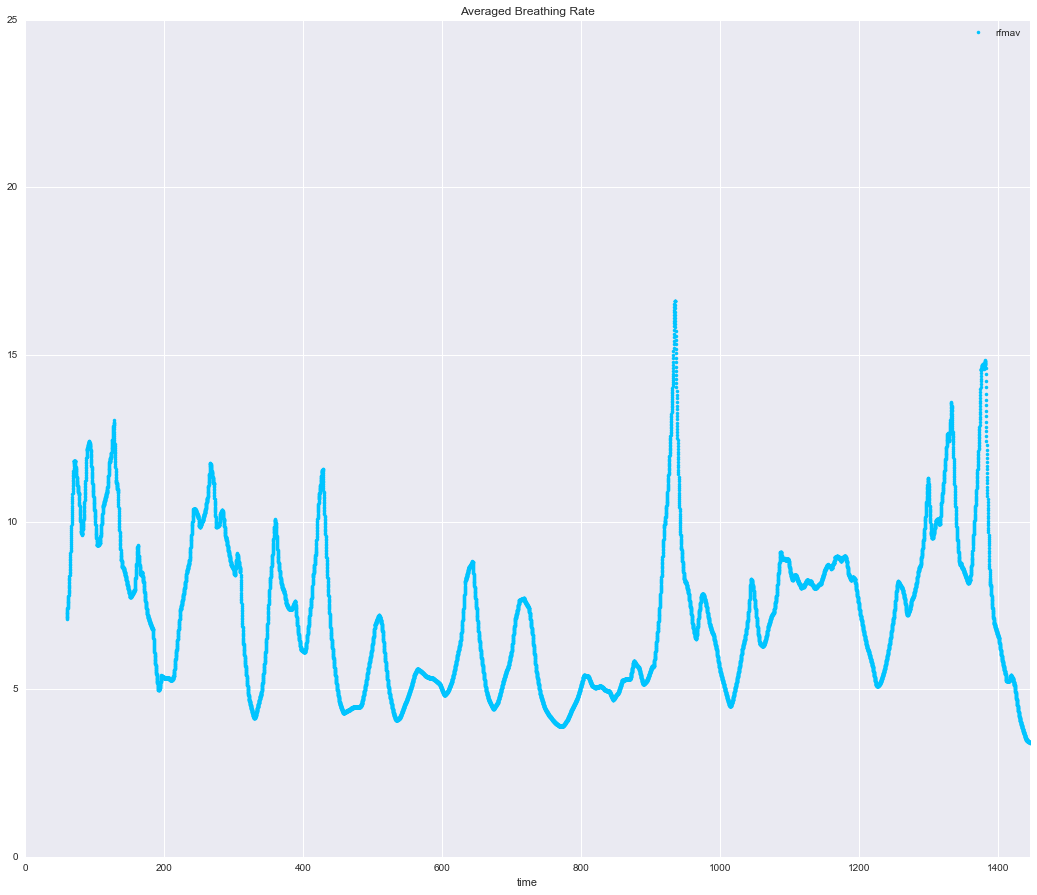

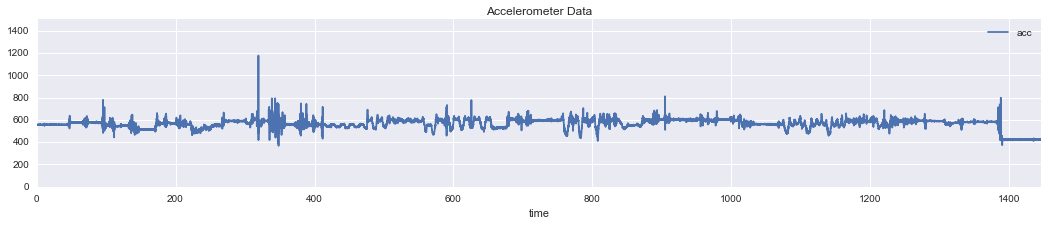

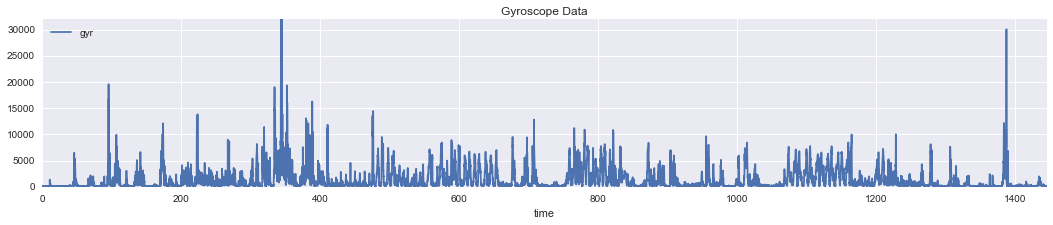

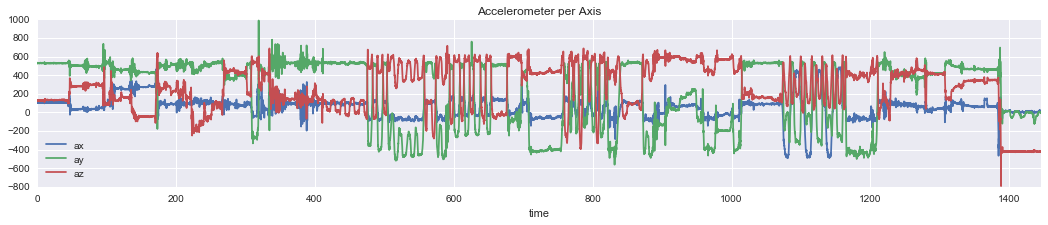

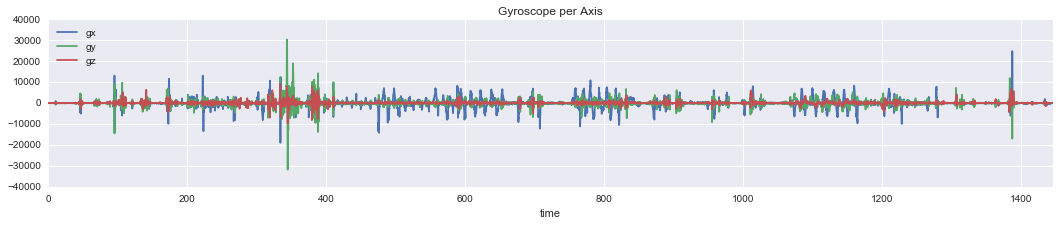

In [45]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,25), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3), ylim=(0,1500), title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3), ylim=(0,32000), title = 'Gyroscope Data')
d.plot(x = 'time',y = ['ax','ay','az'],figsize = (18,3), title = 'Accelerometer per Axis')
d.plot(x = 'time',y = ['gx','gy','gz'],figsize = (18,3), title = 'Gyroscope per Axis')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [46]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az    gx    gy    gz    time  ...   \
0          0   2202   2190  103  534  127   -42    10    96     0.0  ...    
1000    1000   2091   2115   92  531   79    99  -186   213   100.0  ...    
2000    2000   2186   2127   86  527  220  -681    68  -149   200.0  ...    
3000    3000   2170   2141   70  401  416   -34    98   311   300.0  ...    
4000    4000   2140   2110   94  463  289 -1519  -718   -79   400.0  ...    
5000    5000   2189   2038  118  524   -1   133  -510  -253   500.0  ...    
6000    6000   2043   2073  143  249  510 -5985  1355   756   600.0  ...    
7000    7000   2184   2059   92  407  408    83  -120    83   700.0  ...    
8000    8000   2043   2035  -16 -200  579 -1679   513 -1002   800.0  ...    
9000    9000   2162   2157  -16 -146  588   -27   -24    85   900.0  ...    
10000  10000   2212   2045   15  -72  600  1214  -300   103  1000.0  ...    
11000  11000   2106   2061  118  153  566  7035  -181  -659  1100.0  ...    

In [47]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1,b2
0,0,2202,2190,103,534,127,-42,10,96,0.0,...,[nan],NaN,NaN,NaN,NaN,NaN,558.474708,105.261579,1900,1600
1,1,2199,2187,103,531,129,-19,-15,101,0.1,...,[nan],NaN,NaN,NaN,NaN,NaN,556.067442,103.860483,1900,1600
2,2,2200,2187,103,528,127,4,-31,59,0.2,...,[nan],NaN,NaN,NaN,NaN,NaN,552.740445,66.768256,1900,1600
3,3,2202,2193,103,531,127,-11,-17,133,0.3,...,[nan],NaN,NaN,NaN,NaN,NaN,555.606875,134.532524,1900,1600
4,4,2201,2195,103,531,126,-27,0,71,0.4,...,[nan],NaN,NaN,NaN,NaN,NaN,555.379150,75.960516,1900,1600
5,5,2202,2191,105,527,127,-6,-18,28,0.5,...,[nan],NaN,NaN,NaN,NaN,NaN,552.162114,33.823069,1900,1600
6,6,2199,2196,102,529,127,3,-13,80,0.6,...,[nan],NaN,NaN,NaN,NaN,NaN,553.510614,81.104870,1900,1600
7,7,2201,2198,106,527,126,-14,-5,94,0.7,...,[nan],NaN,NaN,NaN,NaN,NaN,552.124080,95.168272,1900,1600
8,8,2199,2198,105,531,127,-41,-13,63,0.8,...,[nan],NaN,NaN,NaN,NaN,NaN,555.981115,76.282370,1900,1600
9,9,2199,2200,103,534,127,-6,-31,76,0.9,...,[nan],NaN,NaN,NaN,NaN,NaN,558.474708,82.298238,1900,1600
